In [ ]:
!pip install torch torchvision numpy matplotlib

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'NIPA/a-yo-image'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

# Change dariectory to current folder
%cd /content/drive/MyDrive/$FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive/NIPA/a-yo-image


In [ ]:
dataset = np.load('./initial-experiments/mongoose/data/data_run_offset_flip.npy')
# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

In [ ]:

# Hyperparameters
latent_dim = 100
batch_size = 64
learning_rate = 0.0002
epochs = 20


In [ ]:
# Generator 네트워크 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Tanh()  # MNIST 이미지의 픽셀값은 [-1, 1] 범위로 정규화됨
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

In [ ]:
# Discriminator 네트워크 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()  # 출력은 진짜(1) 또는 가짜(0)를 나타내는 확률
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [ ]:
# 생성자와 판별자 인스턴스 생성
generator = Generator()
discriminator = Discriminator()

In [ ]:
# 손실 함수 및 옵티마이저 설정
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

In [ ]:

# 학습 루프
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # 실제 이미지에 대한 타겟 레이블 (1)
        real = torch.ones(imgs.size(0), 1)
        # 가짜 이미지에 대한 타겟 레이블 (0)
        fake = torch.zeros(imgs.size(0), 1)

        # -----------------
        #  판별자 학습
        # -----------------
        optimizer_D.zero_grad()

        # 실제 이미지로 판별자 학습
        real_imgs = imgs
        validity_real = discriminator(real_imgs)
        d_real_loss = adversarial_loss(validity_real, real)

        # 생성된 가짜 이미지로 판별자 학습
        z = torch.randn(imgs.size(0), latent_dim)
        gen_imgs = generator(z)
        validity_fake = discriminator(gen_imgs)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # 판별자 손실 계산 및 업데이트
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  생성자 학습
        # -----------------
        optimizer_G.zero_grad()

        # 가짜 이미지 생성 및 판별자를 속이도록 생성자 학습
        z = torch.randn(imgs.size(0), latent_dim)
        gen_imgs = generator(z)
        validity = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, real)

        # 생성자 손실 계산 및 업데이트
        g_loss.backward()
        optimizer_G.step()

        # 로그 출력
        print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

    # Epoch이 끝날 때 샘플 이미지 출력
    if epoch % 5 == 0:
        gen_imgs = gen_imgs.view(gen_imgs.size(0), 1, 28, 28)
        plt.figure(figsize=(10, 10))
        for k in range(25):
            plt.subplot(5, 5, k+1)
            plt.imshow(gen_imgs[k].detach().numpy().squeeze(), cmap='gray')
            plt.axis('off')
        plt.show()


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:01<00:00, 5077372.74it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 148843.33it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1410548.28it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 4337552.09it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

[Epoch 0/20] [Batch 0/938] [D loss: 0.7152841091156006] [G loss: 0.7255160212516785]
[Epoch 0/20] [Batch 1/938] [D loss: 0.6305105090141296] [G loss: 0.7201839089393616]
[Epoch 0/20] [Batch 2/938] [D loss: 0.5656830072402954] [G loss: 0.7142105102539062]
[Epoch 0/20] [Batch 3/938] [D loss: 0.5103828310966492] [G loss: 0.7077893018722534]
[Epoch 0/20] [Batch 4/938] [D loss: 0.46379736065864563] [G loss: 0.7008663415908813]
[Epoch 0/20] [Batch 5/938] [D loss: 0.4311887323856354] [G loss: 0.6922656297683716]
[Epoch 0/20] [Batch 6/938] [D loss: 0.40827447175979614] [G loss: 0.6826691031455994]
[Epoch 0/20] [Batch 7/938] [D loss: 0.3934996724128723] [G loss: 0.6701253652572632]
[Epoch 0/20] [Batch 8/938] [D loss: 0.389351487159729] [G loss: 0.656561017036438]
[Epoch 0/20] [Batch 9/938] [D loss: 0.3912040889263153] [G loss: 0.6416789293289185]
[Epoch 0/20] [Batch 10/938] [D loss: 0.3954109251499176] [G loss: 0.6256742

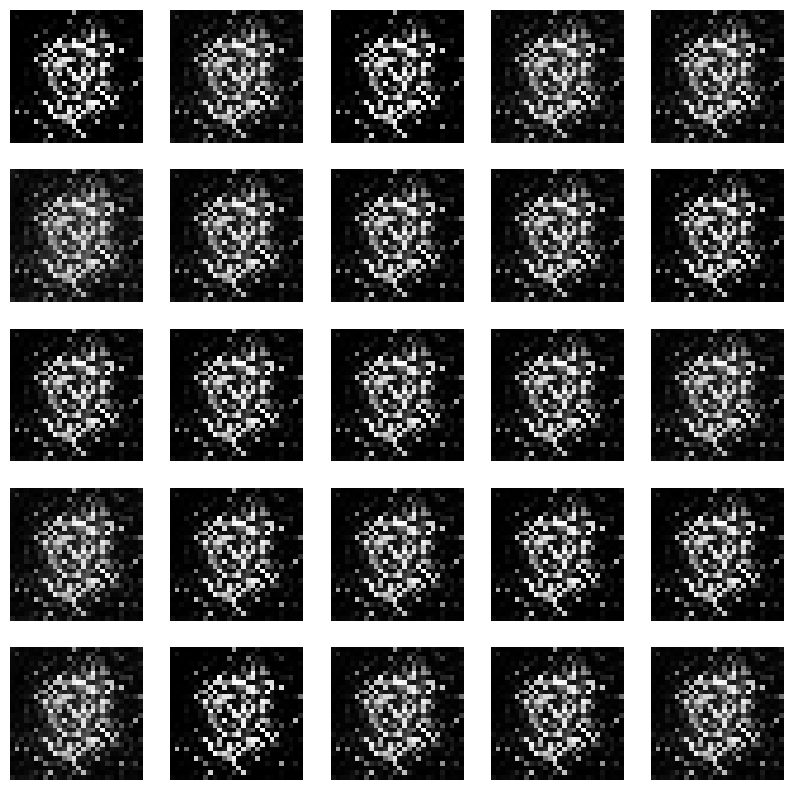

[Epoch 1/20] [Batch 0/938] [D loss: 0.1591363549232483] [G loss: 5.13374137878418]
[Epoch 1/20] [Batch 1/938] [D loss: 0.24521785974502563] [G loss: 5.286228656768799]
[Epoch 1/20] [Batch 2/938] [D loss: 0.10339430719614029] [G loss: 7.507059574127197]
[Epoch 1/20] [Batch 3/938] [D loss: 0.12244877219200134] [G loss: 8.240236282348633]
[Epoch 1/20] [Batch 4/938] [D loss: 0.06677107512950897] [G loss: 7.876095294952393]
[Epoch 1/20] [Batch 5/938] [D loss: 0.06524639576673508] [G loss: 6.666351318359375]
[Epoch 1/20] [Batch 6/938] [D loss: 0.07742145657539368] [G loss: 5.662111282348633]
[Epoch 1/20] [Batch 7/938] [D loss: 0.14447449147701263] [G loss: 5.3670454025268555]
[Epoch 1/20] [Batch 8/938] [D loss: 0.1592739373445511] [G loss: 5.935968399047852]
[Epoch 1/20] [Batch 9/938] [D loss: 0.122749462723732] [G loss: 6.624396324157715]
[Epoch 1/20] [Batch 10/938] [D loss: 0.16441813111305237] [G loss: 6.406332015991211]
[Epoch 1/20] [Batch 11/938] [D loss: 0.20783323049545288] [G loss: 4

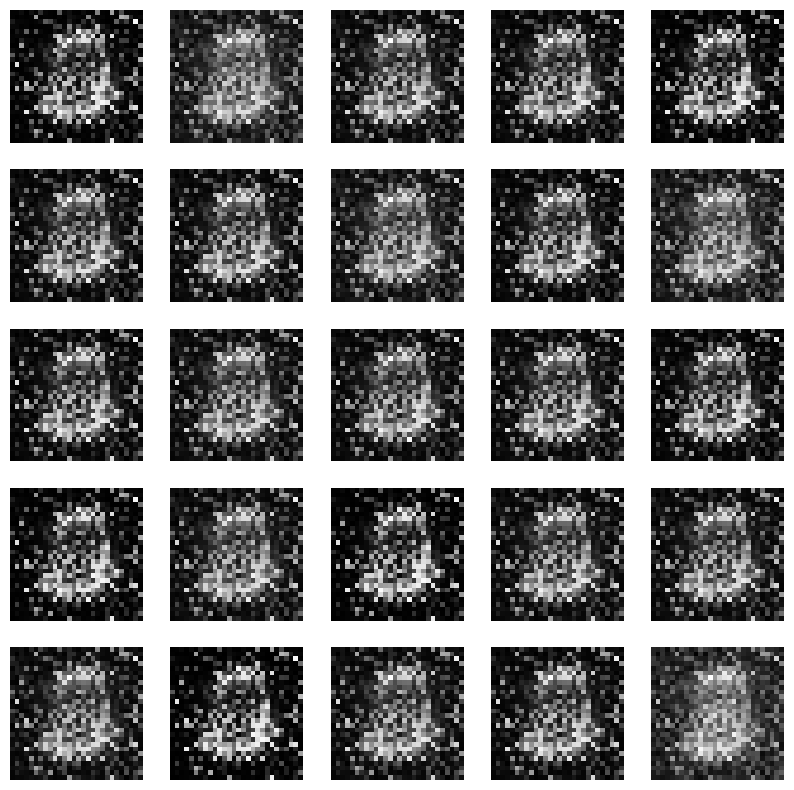

[Epoch 6/20] [Batch 0/938] [D loss: 0.0842738002538681] [G loss: 6.370962619781494]
[Epoch 6/20] [Batch 1/938] [D loss: 0.07160225510597229] [G loss: 6.967383861541748]
[Epoch 6/20] [Batch 2/938] [D loss: 0.18574053049087524] [G loss: 6.788155555725098]
[Epoch 6/20] [Batch 3/938] [D loss: 0.033641401678323746] [G loss: 7.125435829162598]
[Epoch 6/20] [Batch 4/938] [D loss: 0.029805315658450127] [G loss: 6.6770548820495605]
[Epoch 6/20] [Batch 5/938] [D loss: 0.06257349252700806] [G loss: 6.521319389343262]
[Epoch 6/20] [Batch 6/938] [D loss: 0.06754792481660843] [G loss: 6.861388206481934]
[Epoch 6/20] [Batch 7/938] [D loss: 0.07279625535011292] [G loss: 7.175055027008057]
[Epoch 6/20] [Batch 8/938] [D loss: 0.06744064390659332] [G loss: 6.583896636962891]
[Epoch 6/20] [Batch 9/938] [D loss: 0.07245089113712311] [G loss: 7.101837635040283]
[Epoch 6/20] [Batch 10/938] [D loss: 0.08357849717140198] [G loss: 7.8010969161987305]
[Epoch 6/20] [Batch 11/938] [D loss: 0.23970282077789307] [G 

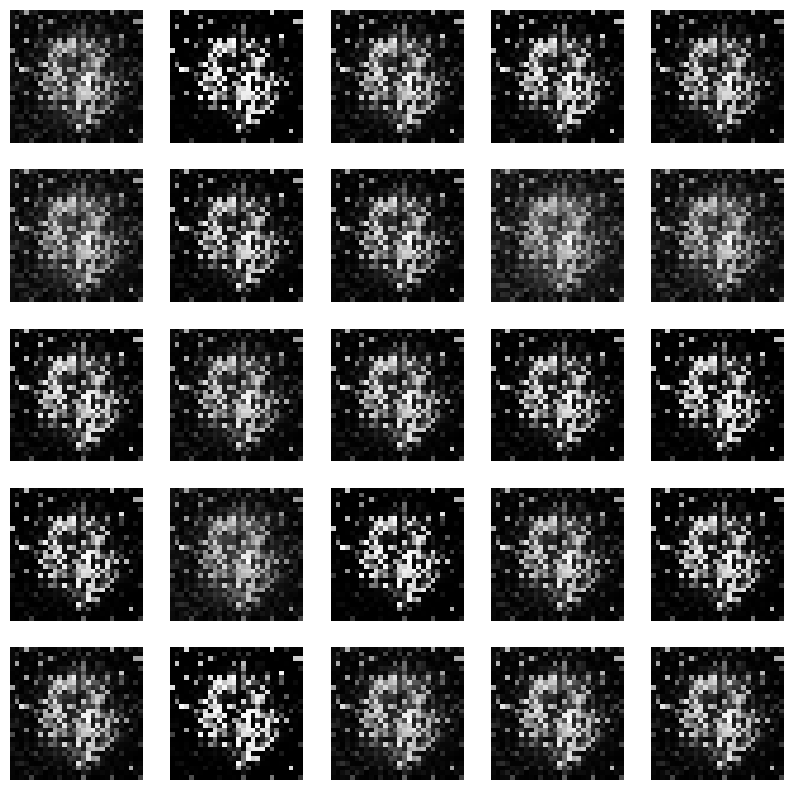

[Epoch 11/20] [Batch 0/938] [D loss: 0.21433719992637634] [G loss: 6.458161354064941]
[Epoch 11/20] [Batch 1/938] [D loss: 0.1395271122455597] [G loss: 5.6738080978393555]
[Epoch 11/20] [Batch 2/938] [D loss: 0.1567671000957489] [G loss: 5.289297103881836]
[Epoch 11/20] [Batch 3/938] [D loss: 0.150602787733078] [G loss: 5.084227085113525]
[Epoch 11/20] [Batch 4/938] [D loss: 0.2336132526397705] [G loss: 5.569804668426514]
[Epoch 11/20] [Batch 5/938] [D loss: 0.31248652935028076] [G loss: 5.313417434692383]
[Epoch 11/20] [Batch 6/938] [D loss: 0.13244709372520447] [G loss: 6.186198711395264]
[Epoch 11/20] [Batch 7/938] [D loss: 0.15697239339351654] [G loss: 5.673222064971924]
[Epoch 11/20] [Batch 8/938] [D loss: 0.10158271342515945] [G loss: 6.01848030090332]
[Epoch 11/20] [Batch 9/938] [D loss: 0.1447231024503708] [G loss: 5.454058647155762]
[Epoch 11/20] [Batch 10/938] [D loss: 0.14692963659763336] [G loss: 5.7732391357421875]
[Epoch 11/20] [Batch 11/938] [D loss: 0.16518375277519226]

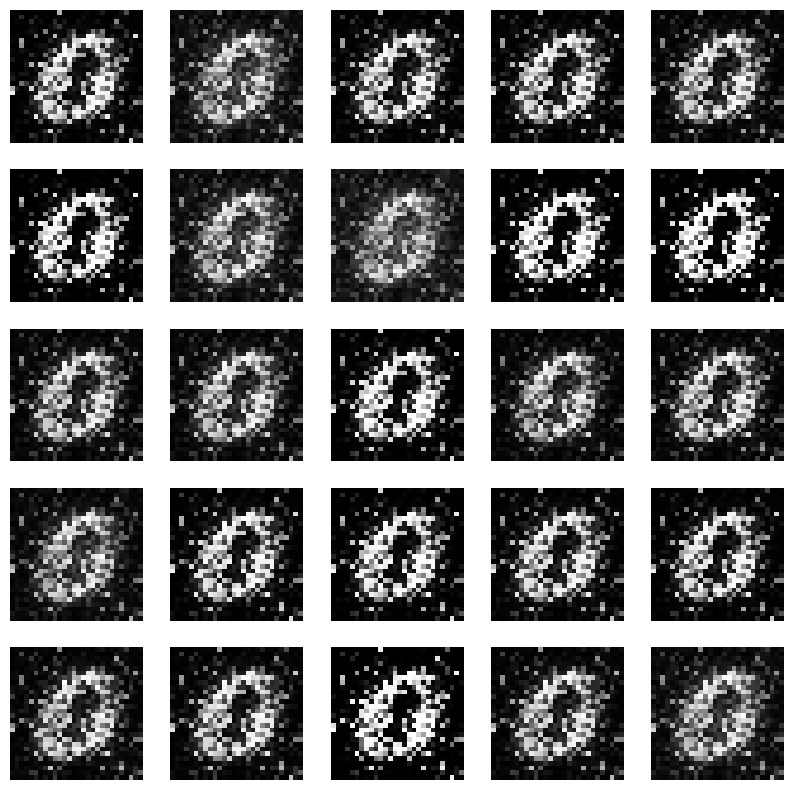

[Epoch 16/20] [Batch 0/938] [D loss: 0.0553029403090477] [G loss: 6.818521499633789]
[Epoch 16/20] [Batch 1/938] [D loss: 0.015210873447358608] [G loss: 6.0289506912231445]
[Epoch 16/20] [Batch 2/938] [D loss: 0.0448308065533638] [G loss: 5.987890243530273]
[Epoch 16/20] [Batch 3/938] [D loss: 0.08384452760219574] [G loss: 6.814871311187744]
[Epoch 16/20] [Batch 4/938] [D loss: 0.04274560138583183] [G loss: 7.831170082092285]
[Epoch 16/20] [Batch 5/938] [D loss: 0.07746592909097672] [G loss: 8.340181350708008]
[Epoch 16/20] [Batch 6/938] [D loss: 0.04760443791747093] [G loss: 8.327720642089844]
[Epoch 16/20] [Batch 7/938] [D loss: 0.049615342170000076] [G loss: 8.043461799621582]
[Epoch 16/20] [Batch 8/938] [D loss: 0.023113911971449852] [G loss: 7.987716197967529]
[Epoch 16/20] [Batch 9/938] [D loss: 0.10174719989299774] [G loss: 6.5262041091918945]
[Epoch 16/20] [Batch 10/938] [D loss: 0.09375039488077164] [G loss: 6.0260210037231445]
[Epoch 16/20] [Batch 11/938] [D loss: 0.066640466

In [ ]:

# MNIST 데이터셋 로드
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(mnist, batch_size=batch_size, shuffle=True)

